# BentoML service preparation & deployment (local and Docker)

If does not exist, import prepared_data.csv into working directory.

Press 'Run All' to:
* Ingest data from prepared_data.csv 
* Prepare and split data for training and testing
* Train model with a single configuration
* Save model into BentoML library
* Create BentoML Service
* Dockerize the Service

Manually, at 'Run service in Docker' deploy docker container. At the end of a file instructions indicate how to test the endpoint.

## Setup

Install required dependencies:

In [ ]:
!pip3 install -r requirements.txt

If you are running MacOS use the following pip command:

In [ ]:
!pip3 install -r requirements-macos.txt

In [ ]:
!pip3 install "bentoml[io-json]"

In [4]:
!bentoml -v

bentoml, version 1.0.13


In [5]:
import bentoml
import tensorflow as tf
import pandas as pd
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Reshape
from tensorflow.keras import Model

## Data ingestion & preparation

In [6]:
# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [7]:
 # load dataset
dataset = pd.read_csv('prepared_data.csv')
dataset = dataset.drop(['date'], axis=1)

values = dataset.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 0, 30)

# drop every column except revenue for prediction
list_to_drop = list(range(len(reframed.columns) // 2, len(reframed.columns)))
del list_to_drop [52-1::52]
reframed.drop(reframed.columns[list_to_drop], axis=1, inplace=True)

In [8]:
# split into train and test sets
values = reframed.values

eighty = int(len(dataset)*0.8)
train = values[:eighty, :]
test = values[eighty:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1409, 1, 794) (1409,) (324, 1, 794) (324,)


## Define the model

In [9]:
n_forecast = 30
num_features = 1

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.lstm = LSTM(32, return_sequences=False)
        self.dense = Dense(n_forecast*num_features)
        self.reshape = Reshape([n_forecast, num_features])

    def call(self, x):
        x = self.lstm(x)
        x = self.dense(x)
        return self.reshape(x)

model = MyModel()

model.compile(loss='mean_squared_error', optimizer='adam')

## Training and Saving the model

Then we initialize some simple tensorflow helper functions and create the training and testing methods

### Training the model

As provided by TensorFlow, we train and test the model.

Epoch 1/200


2023-02-08 05:25:04.013686: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 - 1s - loss: 0.0758 - val_loss: 0.0733 - 1s/epoch - 94ms/step
Epoch 2/200
15/15 - 0s - loss: 0.0631 - val_loss: 0.0508 - 65ms/epoch - 4ms/step
Epoch 3/200
15/15 - 0s - loss: 0.0488 - val_loss: 0.0402 - 54ms/epoch - 4ms/step
Epoch 4/200
15/15 - 0s - loss: 0.0445 - val_loss: 0.0335 - 55ms/epoch - 4ms/step
Epoch 5/200
15/15 - 0s - loss: 0.0418 - val_loss: 0.0299 - 62ms/epoch - 4ms/step
Epoch 6/200
15/15 - 0s - loss: 0.0377 - val_loss: 0.0261 - 52ms/epoch - 3ms/step
Epoch 7/200
15/15 - 0s - loss: 0.0328 - val_loss: 0.0217 - 51ms/epoch - 3ms/step
Epoch 8/200
15/15 - 0s - loss: 0.0277 - val_loss: 0.0180 - 68ms/epoch - 5ms/step
Epoch 9/200
15/15 - 0s - loss: 0.0228 - val_loss: 0.0152 - 53ms/epoch - 4ms/step
Epoch 10/200
15/15 - 0s - loss: 0.0190 - val_loss: 0.0140 - 53ms/epoch - 4ms/step
Epoch 11/200
15/15 - 0s - loss: 0.0167 - val_loss: 0.0139 - 51ms/epoch - 3ms/step
Epoch 12/200
15/15 - 0s - loss: 0.0154 - val_loss: 0.0131 - 48ms/epoch - 3ms/step
Epoch 13/200
15/15 - 0s - loss: 0.0149

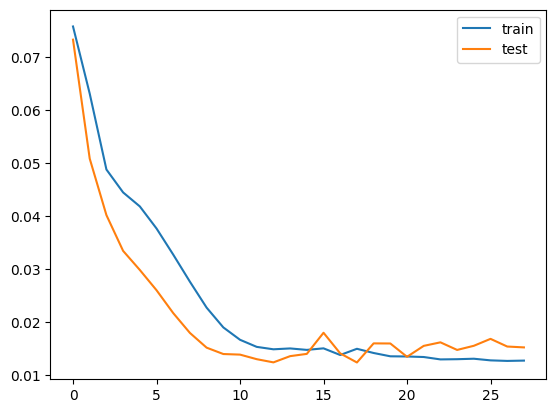

In [10]:
# stop earlier to avoid overfitting 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=10,
                                                    mode='min')

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=100, 
    validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Saving the model

Make one call to the bentoml library to save this tensorflow model to be used later as part of the prediction service that we will create.

In [11]:
bentoml.tensorflow.save_model(
    "tensorflow_lstm",
    model,
    signatures={"__call__": {"batchable": True, "batch_dim": 0}},
)

INFO:tensorflow:Assets written to: /var/folders/x4/ln2jnbvn4y77s5yjv_4l60p00000gn/T/tmpdrwjstk5bentoml_model_tensorflow_lstm/assets


INFO:tensorflow:Assets written to: /var/folders/x4/ln2jnbvn4y77s5yjv_4l60p00000gn/T/tmpdrwjstk5bentoml_model_tensorflow_lstm/assets


Model(tag="tensorflow_lstm:f5ama7vhmcw274wm", path="/Users/domas/bentoml/models/tensorflow_lstm/f5ama7vhmcw274wm/")

List all create models in bentoml library.

In [12]:
# !bentoml models list

## Create a BentoML Service for serving the model

Note: using `%%writefile` here because `bentoml.Service` instance must be created in a separate `.py` file

Script below creates a single endpoint `predict31`, which will predict from 31 days history into next 31 days.


In [13]:
%%writefile service.py

import bentoml
import numpy as np
import pandas as pd
from bentoml.io import Image, NumpyNdarray, JSON
from sklearn.preprocessing import MinMaxScaler
from pydantic import BaseModel
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

# create a runner for a predictions using just trained model
runner = bentoml.tensorflow.get("tensorflow_lstm:latest").to_runner()

# create a service endpoint
svc = bentoml.Service(
    name="tensorflow_lstm_demo",
    runners=[runner],
)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

@svc.api(input=JSON(), output=NumpyNdarray(dtype="float32"))
async def predict30(input_data: JSON) -> "np.ndarray":

    # Ingest data
    data = pd.DataFrame(input_data).T
    data = data.drop(['date'], axis=1)

    values = data.values

    # Normalize
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # Reshape
    reframed = series_to_supervised(scaled, 0, 30)

    # drop every column except revenue for prediction
    list_to_drop = list(range(len(reframed.columns) // 2, len(reframed.columns)))
    del list_to_drop [52-1::52]
    reframed.drop(reframed.columns[list_to_drop], axis=1, inplace=True)


    # prepare data for model
    values= reframed.values
    test = values[:len(data), :]
    test_X, test_y = test[:, :-1], test[:, -1]
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # predict
    yhat  = await runner.async_run(test_X)

    # transform and retreive results
    results = []
    for i in range(30):
        test_X[0, 0, -1] = yhat[0, i, 0]
        result_day = scaler.inverse_transform(test_X[:, 0, -52:])
        results.append(result_day[0, -1])

    return np.array(results)



Overwriting service.py


Start a dev model server with the comand below (for local testing)

In [14]:
# !bentoml serve service.py:svc --reload

### Test local endpoint

If using file from data notebook

`curl -X POST -H "Content-Type: application/json" -d @test.json http://0.0.0.0:3000/predict30`

or alternatively, python request:

In [15]:
# ### test from other notebook, since server is running here

# import requests

# url = 'http://0.0.0.0:3000/predict30'
# headers = {"content-type": "application/json"}
# r = requests.post(url, data=open('test.json', 'rb'), headers=headers).text

# print(r)

## Build a Bento for distribution and deployment

Note: if running, stop the server above to proceed

A `bentofile` is already created in this directory  with all the necessary packages for building a Bento for the service:

```yaml
service: "service:svc"
description: "file: ./README.md"
labels:
  owner: Domas
  stage: demo
include:
  - "*.py"
exclude:
  - "locustfile.py"
python:
  lock_packages: false
  packages:
    - tensorflow
    - Pillow
    - pandas
    - scikit-learn
    - pydantic

```

Run `bentoml build` from current directory to build a Bento with the latest version of the `tensorflow_lstm_demo` model. This may take a while when running for the first time for BentoML to resolve all dependency versions:

In [16]:
!bentoml build

Building BentoML service "tensorflow_lstm_demo:gn4jasvhmciad4wm" from build context "/Users/domas/bentoml/gitrepo/b_exercise/BentoML".
Packing model "tensorflow_lstm:f5ama7vhmcw274wm"

██████╗░███████╗███╗░░██╗████████╗░█████╗░███╗░░░███╗██╗░░░░░
██╔══██╗██╔════╝████╗░██║╚══██╔══╝██╔══██╗████╗░████║██║░░░░░
██████╦╝█████╗░░██╔██╗██║░░░██║░░░██║░░██║██╔████╔██║██║░░░░░
██╔══██╗██╔══╝░░██║╚████║░░░██║░░░██║░░██║██║╚██╔╝██║██║░░░░░
██████╦╝███████╗██║░╚███║░░░██║░░░╚█████╔╝██║░╚═╝░██║███████╗
╚═════╝░╚══════╝╚═╝░░╚══╝░░░╚═╝░░░░╚════╝░╚═╝░░░░░╚═╝╚══════╝

Successfully built Bento(tag="tensorflow_lstm_demo:gn4jasvhmciad4wm").


### Dockerize

Put `Bento` into `Docker` container.
Make sure the docker service itself is running before start.
This might take some time.

In [ ]:
!bentoml containerize tensorflow_lstm_demo:latest

### Run service in Docker container

After container is prepared, the very last line shows a default command to run docker container. Run it to start the service.

In [23]:
# run using command above
# similar to described below (make sure to begin with '!')
# !docker run -it --rm -p 3000:3000 tensorflow_lstm_demo:djls6yvhbspzn4wm serve --production

### Test Docker endpoint

If using file from data notebook

`curl -X POST -H "Content-Type: application/json" -d @test.json http://0.0.0.0:3000/predict30`

or alternatively, python request:

In [ ]:
# ### test from other notebook, since server is running here

# import requests

# url = 'http://0.0.0.0:3000/predict31'
# headers = {"content-type": "application/json"}
# r = requests.post(url, data=open('file-3.json', 'rb'), headers=headers).text

# print(r)